In [1]:

import matplotlib.pyplot as plt
import numpy as np
import blip_analysis as ba
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix
import exp_blip_models as em
import matplotlib
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix
from label_axes import label_axes
import json
import scipy
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
### Load in some data including the full classifier results

full_res = pickle.Unpickler(open('../Data/230315_full_classifier_RFs.pkl', 'rb')).load()
glyphs = ba.get_glyphs()
scores = full_res[:, :, 0].astype(float)
preds = full_res[:, :, 1]
preds_corrected = np.array([[np.stack(i) for i in j] for j in preds])
preds_flat = preds_corrected.reshape((preds_corrected.shape[0], preds_corrected.shape[1] * preds_corrected.shape[2]))

### These are the distance embeddings for the 3 odours
res1 = np.load('../Fig2/221026_de_1d_res_odour1_extended.npy')
res2 = np.load('../Fig2/221027_de_1d_res_odour2_extended.npy')
res3 = np.load('../Fig2/221027_de_1d_res_odour3_extended.npy')
res1 = np.array(res1).reshape(50, 162, 32)
res2 = np.array(res2).reshape(50, 162, 32)
res3 = np.array(res3).reshape(50, 162, 32)
style_params = json.load(open('../Data/style_params.json', 'r'))
classifier_cmap = style_params['classifier_cm_color']
odour_labels = style_params['odour_labels']

In [3]:
### Make connfusion matrices
trues = [i for j in range(100) for i in range(32)]
cms = np.array([confusion_matrix(trues, preds_flat[i], normalize='true') for i in range(3)])

In [4]:

### Flip the distances if needed
closests1 = [res1[0, 0]]
closests2 = [res2[0, 0]]
closests3 = [res3[0, 0]]
for i in range(1, 162):
    prev_distance = closests1[-1]
    diffs = np.mean(np.abs(res1[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests1.append(res1[min_diff, i])
    
    prev_distance = closests2[-1]
    diffs = np.mean(np.abs(res2[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests2.append(res2[min_diff, i])
    
    prev_distance = closests3[-1]
    diffs = np.mean(np.abs(res3[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests3.append(res3[min_diff, i])

In [5]:
def plot_1d_distance_graph(xs, distances, ax, colors=None, cmap=matplotlib.cm.plasma):
    '''Plot a 1d distance graph for part A'''

    distances = np.array(distances)
    trial_len = distances.shape[1]
    if colors is None:
        colors = [cmap(i/trial_len) for i in range(trial_len)]

    print(len(colors))
    for index, i in enumerate(distances.T):
        ax.plot(xs, i, color=colors[index])
    ax.axvspan(0, 0.1, color='lightgray')
    
def distance_plots(fig, gs_base, xs, closests, cmap=matplotlib.cm.plasma, hspace=0.5):
    '''Overall plotting function for part A'''

    sub_gridspec = gs_base.subgridspec(ncols=14, nrows=2, wspace=1.5, hspace=hspace)
    big_ax = fig.add_subplot(sub_gridspec[0, 2:])
    small_ax1 = fig.add_subplot(sub_gridspec[1, 2:6])
    small_ax2 = fig.add_subplot(sub_gridspec[1, 6:10])
    small_ax3 = fig.add_subplot(sub_gridspec[1, 10:])
    
    small_ax2.set_yticklabels([])
    small_ax3.set_yticklabels([])
    plot_1d_distance_graph(xs, closests1, big_ax, cmap=cmap)

    cbar_ax = fig.add_subplot(sub_gridspec[:, 0])
    cbar_ax.yaxis.set_ticks_position('left')
    plot_cbar_and_glyphs(cbar_ax, glyphs, cmap.reversed())
    cbar_ax.yaxis.set_ticks_position('left')
    plot_1d_distance_graph(xs[50:70], closests1[50:70], small_ax1, cmap=cmap)
    plot_1d_distance_graph(xs[50:70], closests2[50:70], small_ax2, cmap=cmap)
    plot_1d_distance_graph(xs[50:70], closests3[50:70], small_ax3, cmap=cmap)
    
    min_max = np.max(np.abs(np.concatenate([small_ax1.get_ylim(), small_ax2.get_ylim(), small_ax3.get_ylim()])))
    small_ax1.set_ylim(-min_max, min_max)
    small_ax2.set_ylim(-min_max, min_max)
    small_ax3.set_ylim(-min_max, min_max)
    label_ax = fig.add_subplot(sub_gridspec[:, 2:], frameon=False)
    label_ax.set_xticks([])
    label_ax.set_yticks([])
    label_ax.set_ylabel('Distance (Hz)', labelpad=27)
    label_ax.set_xlabel('Time (s)', labelpad=20)
    return [big_ax, small_ax1, small_ax2, small_ax3]
def plot_cbar_and_glyphs(ax, glyphs, cmap):
    '''Plot the colorbar for part A'''
    im = ax.imshow(np.array([[0, 1]]), aspect=30, cmap=cmap)
    cbar = plt.colorbar(cax=ax, mappable=im)
    cbar.set_ticks(np.linspace(0, 1, len(glyphs)))
    cbar.set_ticklabels(glyphs[::-1])


In [6]:
### Two halves of the data confusion matrices - each one is constructed from disctinct data from the other
half_dict = pickle.Unpickler(open('../Data/230425_half_dict.p', 'rb')).load()
cm_half1 = confusion_matrix(half_dict['trues'].flatten(), half_dict['pred1'].flatten(), normalize='true', labels=range(32))
cm_half2 = confusion_matrix(half_dict['trues'].flatten(), half_dict['pred2'].flatten(), normalize='true', labels=range(32))

In [7]:
### faux distance matrices

### Label each trial by either the onset or the concentration
labs_onset = np.where(em.trial_arrays['cao_array'][:, :5] == 1)[1]
labs_conc = np.where(em.trial_arrays['cao_array'][:, 5:] == 1)[1]
labs_conc = np.append([-1], labs_conc)
labs_onset = np.append([5], labs_onset)

### Construct the Distance matrices
dm_conc = distance_matrix(labs_conc[:, np.newaxis], labs_conc[:, np.newaxis])
dm_onset = distance_matrix(labs_onset[:, np.newaxis], labs_onset[:, np.newaxis])

def plot_faux_distance_matrices(fig, glob_gs, dms, glyphs, titles=None, cmap='viridis', rotate=False, cbar=True, fs=6):
    '''Plot the faux distance matrices for part E'''
    if cbar:
        sub_gs = glob_gs.subgridspec(ncols=22, nrows=2, hspace=0.3)
    else:
        sub_gs = glob_gs.subgridspec(ncols=20, nrows=2, hspace=0.3)
    axs = []
    max_dm = np.max([np.max(i) for i in dms])
    min_dm = np.min([np.min(i) for i in dms])
    for i, dm in enumerate(dms):
        if rotate:
            ax = fig.add_subplot(sub_gs[:, i*11:(i+1)*9+2*i])
        else:
            ax = fig.add_subplot(sub_gs[i, :20])
        im = ax.imshow(dm, cmap=cmap, vmax=max_dm, vmin=min_dm)
        
        ax.set_xticks(range(32))
        ax.set_yticks(range(32))
        ax.set_yticklabels(glyphs, fontsize=fs)
        ax.set_ylim(31.5, -0.5)
        if titles is not None:
            ax.set_title(titles[i])
        ax.set_xticklabels([])
        axs.append(ax)
    axs[1].set_xticklabels(glyphs, rotation=90, fontsize=fs)
    if rotate:
        #axs[1].set_yticklabels([])
        axs[0].set_xticklabels(glyphs, rotation=90, fontsize=fs)
    if cbar:
        cbar_ax = fig.add_subplot(sub_gs[:, -1])
        colorbar = fig.colorbar(im, cax=cbar_ax)
        axs.append(cbar_ax)
    return axs, im
def full_loss(x):
    ws = x @ em.trial_arrays['cao_array'].T
    dm = distance_matrix(ws[:, np.newaxis], ws[:, np.newaxis])
    return 1 - abs(np.corrcoef(dm.ravel(), cms[0].ravel())[0, 1])

### Find the optimized combo distance matrix
opt = scipy.optimize.minimize(full_loss, np.ones(10), method='Nelder-Mead', options={'maxiter':10000})
preds = opt.x @ em.trial_arrays['cao_array'].T
dm = distance_matrix(preds[:, np.newaxis], preds[:, np.newaxis])


In [8]:
def plot_heatmap(ax, data, title, vmax, cmap=classifier_cmap, fontsize=8):
    '''Plot a heatmap for part C with the trail classifier confusion matrices'''
    im = ax.imshow(data, cmap=cmap, vmin=0, vmax=vmax)
    ax.set_xticks(range(32))
    ax.set_yticks(range(32))
    ax.set_yticklabels([])
    ax.set_ylim(31.5, -0.5)
    ax.set_title(title)
    ax.set_xticklabels(glyphs, rotation=90, fontsize=fontsize)
    ax.set_xlabel('Predicted')
    return im

def plot_all_heatmaps(fig, glob_gs, cms, fontsize=8, titles = odour_labels):
    '''Plot all three heatmaps for part C'''
    gs = glob_gs.subgridspec(1, 3, wspace=0.1)
    axs = [fig.add_subplot(gs[i]) for i in range(3)]
    global_vmax = np.max([np.max(np.abs(cms[i])) for i in range(3)])
    ims = [plot_heatmap(axs[i], cms[i], titles[i], global_vmax, fontsize=fontsize) for i in range(3)]
    axs[0].set_yticklabels(glyphs, fontsize=fontsize)
    axs[0].set_ylabel('True')

    return ims, axs

32
32
32
32


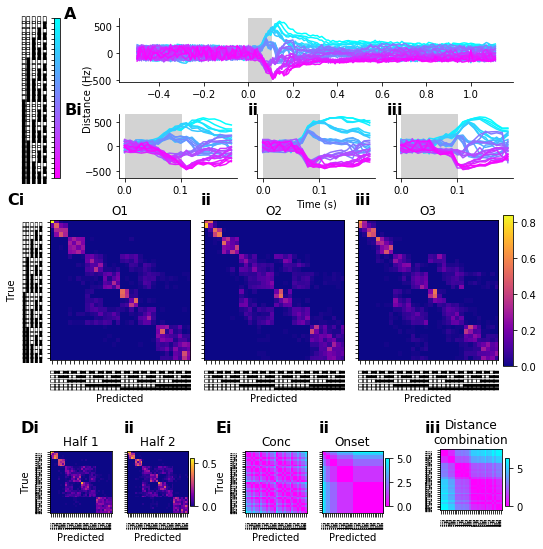

In [9]:
### Plotting
fig = plt.figure(figsize=(8.3, 10))
gs = GridSpec(3,1)

xs = np.arange(-.5, 1.12, 1/100)
### Make the distance plots
distance_axs = distance_plots(fig, gs[0], xs, np.array([closests1, closests2, closests3]), cmap=matplotlib.cm.cool)
[i.spines['right'].set_visible(False) for i in distance_axs]
[i.spines['top'].set_visible(False) for i in distance_axs]

### Make the classifier heatmaps
sub_gs = gs[1].subgridspec(ncols=31, nrows=1, wspace=0.5)
ims, heatmap_axs = plot_all_heatmaps(fig, sub_gs[:-1], cms)
cbar_ax = fig.add_subplot(sub_gs[-1], aspect=15)
cbar = fig.colorbar(ims[0], cax=cbar_ax)


### Make the axis for the combo distance matrix
sub_gs = gs[2].subgridspec(1, 29, wspace=1)
combo_ax = fig.add_subplot(sub_gs[-5:-1])
combo_cbax = fig.add_subplot(sub_gs[-1])
im = combo_ax.imshow(dm, cmap='cool_r')
combo_ax.set_xticks(range(32))
combo_ax.set_yticks(range(32))
combo_ax.set_yticklabels(glyphs, fontsize=3)
combo_ax.set_ylim(31.5, -0.5)
combo_ax.set_xticks(range(32))
combo_ax.set_xticklabels(glyphs, rotation=90, fontsize=3)
plt.colorbar(im, cax=combo_cbax)

##
# shift it over a little bit
combo_ax_cbar = combo_cbax.get_position()
new_pos = [combo_ax_cbar.x0, combo_ax_cbar.y0+(combo_ax_cbar.height/2)-(combo_ax_cbar.height*0.3/2), combo_ax_cbar.width*0.5, combo_ax_cbar.height*0.3]
combo_cbax.set_position(new_pos)


### Make the onset and conc distance matrices
dm_axs, dm_im = plot_faux_distance_matrices(fig, sub_gs[12:21], [dm_conc, dm_onset], glyphs, ['Conc', 'Onset'], rotate=True, cmap='cool_r', cbar=False, fs=3)
half_axs, half_dm = plot_faux_distance_matrices(fig, sub_gs[:9], [cm_half1, cm_half2], glyphs, ['Half 1', 'Half 2'], rotate=True, cmap='plasma', cbar=False, fs=3)
dm_cbar = fig.add_subplot(sub_gs[21])
dm_cbar_pos = dm_cbar.get_position()
new_pos = [dm_cbar_pos.x0-0.01, dm_cbar_pos.y0+(dm_cbar_pos.height/2)-(dm_cbar_pos.height*0.3/2), dm_cbar_pos.width*0.5, dm_cbar_pos.height*0.3]
dm_cbar.set_position(new_pos)
dm_cbar_im = fig.colorbar(dm_im, cax=dm_cbar)
dm_axs[1].set_yticklabels([])
dm_axs[0].set_xlabel('Predicted')
dm_axs[1].set_xlabel('Predicted')
dm_axs[0].set_ylabel('True')

### Make the half distance matrices
half_cbar = fig.add_subplot(sub_gs[9])
half_cbar_pos = half_cbar.get_position()
new_pos = [half_cbar_pos.x0-0.01, half_cbar_pos.y0+(half_cbar_pos.height/2)-(half_cbar_pos.height*0.3/2), half_cbar_pos.width*0.5, half_cbar_pos.height*0.3]
half_cbar.set_position(new_pos)
half_cbar_im = fig.colorbar(half_dm, cax=half_cbar)
half_axs[1].set_yticklabels([])
half_axs[0].set_xlabel('Predicted')
half_axs[1].set_xlabel('Predicted')
half_axs[0].set_ylabel('True')

### Label the axes
combo_ax.set_position([combo_ax.get_position().x0, combo_ax.get_position().y0, half_axs[0].get_position().width, half_axs[0].get_position().height])
combo_ax.set_title('Distance\ncombination')
axes = [*distance_axs, *heatmap_axs, *dm_axs, *half_axs, combo_ax, combo_cbax, dm_cbar, half_cbar]
labels = ['A', 'Bi', 'ii', 'iii', 'Ci', 'ii', 'iii', 'Ei', 'ii', 'Di', 'ii', 'iii']
align_x = [[0, 1]]
align_y = [[1, 2, 3], [4, 5, 6], [7, 8, 9, 10, 11]]
dx = [-0.035, -0.035, -0.01, -0.01, 0, 0, 0, 0, 0, 0, 0, 0]
label_axes.label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', dx=dx)
#plt.savefig('230703_fig3.pdf', bbox_inches='tight')

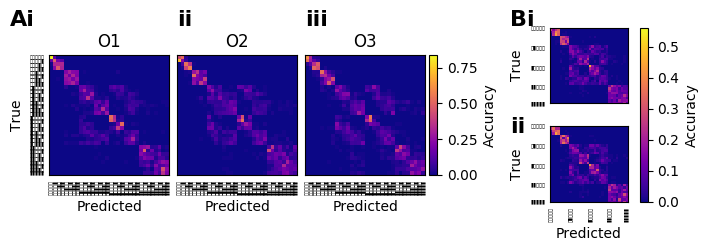

In [13]:
fig = plt.figure(figsize=(8, 2.3), dpi=100)
gs = fig.add_gridspec(2, 3, wspace=0.6, hspace=0.1)
ims, heatmap_axs = plot_all_heatmaps(fig, gs[:, :-1], cms, fontsize=4)
[i.tick_params(axis=u'both', which=u'both',length=0) for i in heatmap_axs]
half_axs, half_dm = plot_faux_distance_matrices(fig, gs[:, -1], [cm_half1, cm_half2], glyphs, titles=None, rotate=False, cmap='plasma', cbar=True, fs=4)
[i.tick_params(axis=u'both', which=u'both',length=0) for i in half_axs[:-1]]
select_trials = [0, 8, 16, 24, 31]
[i.set_xticks(select_trials) for i in half_axs[:-1]]
[i.set_yticks(select_trials) for i in half_axs[:-1]]
[i.set_xticklabels(np.array(glyphs)[select_trials]) for i in [half_axs[1]]]
[i.set_yticklabels(np.array(glyphs)[select_trials]) for i in half_axs[:-1]]
adjust_metic = 0.01
for index, ax in enumerate(heatmap_axs):
    pos = ax.get_position()
    pos.x0 -= adjust_metic*index
    ax.set_position(pos)
cbar_ax = fig.add_axes([0.6, 0.15, 0.01, 0.7])
cbar_ax_pos = cbar_ax.get_position()
cbar_ax.set_position([cbar_ax_pos.x0, pos.y0, cbar_ax_pos.width, pos.height])

plt.colorbar(ims[0], cax=cbar_ax)
cbar_ax.set_ylabel('Accuracy')
cbar_pos = half_axs[-1].get_position()
half_axs[-1].set_position([cbar_pos.x0-0.03, cbar_pos.y0, cbar_ax_pos.width, cbar_pos.height])
axs = heatmap_axs + half_axs
align_x = [[3, 4]]
align_y = [[0, 1, 2, 3]]
labs = ['Ai', 'ii', 'iii', 'Bi', 'ii']
dx = [0, 0, 0, -0.025, -0.025]
dy = [0, 0, 0, 0, -0.04]
label_axes.label_axes(axs, labs, fontsize=16, fontweight='bold', align_y=align_y, align_x=align_x, align_x_fun=np.min, align_y_fun=np.max, dx=dx, dy=dy)
half_axs[1].set_xlabel('Predicted')
half_axs[1].set_ylabel('True')
half_axs[0].set_ylabel('True')
half_axs[-1].set_ylabel('Accuracy')
plt.savefig('230821_Fig3.pdf', bbox_inches='tight')

In [74]:
select_trials = [0, 4, 8, 16, 24, 31]
print(np.array(glyphs)[select_trials])

['▯▯▯▯▯' '▯▯▮▯▯' '▯▮▯▯▯' '▮▯▯▯▯' '▮▮▯▯▯' '▮▮▮▮▮']


In [15]:
print(cms.shape)
print(np.diag(cms[0]).mean())
print(np.diag(cms[1]).mean())
print(np.diag(cms[2]).mean())
print(1/32)

(3, 32, 32)
0.245
0.203125
0.2134375
0.03125
